# Trignometric Function Prediction by RNN 2

## What's new?
    1. Naive implementation of a two-layered recurrent neural network using `nn.Module`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


# This shows good pic: format from classic style; color and style from seaborn
plt.style.use('classic')
plt.style.use('seaborn')


# Hyper-Parameters
TIME_STEP = 50      # mini-batch size
SKIP = 3            # skip some time-steps to prepare hidden state in mini-batch training

INPUT_SIZE = 1      # rnn input size
HIDDEN_SIZE = 8     # rnn hidden size
OUTPUT_SIZE = 1     # rnn output size

LR = 1e-2           # learning rate

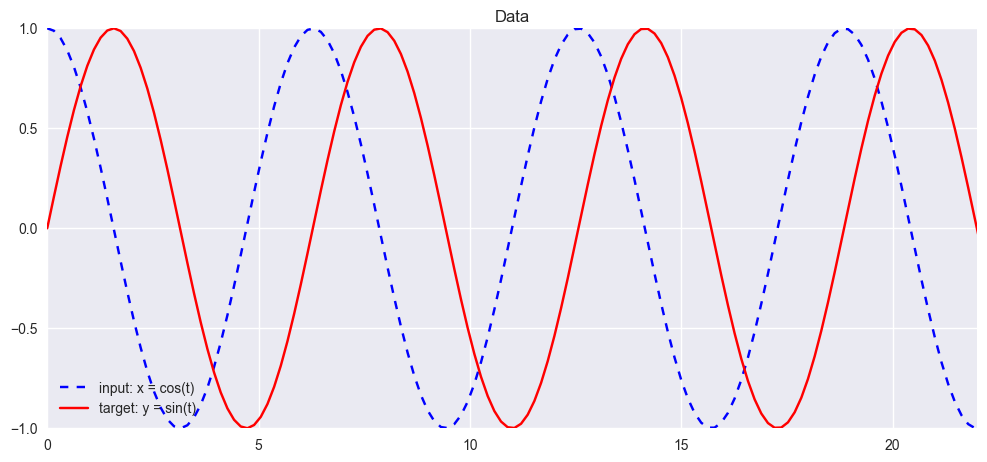

In [2]:
# Generate data: train a RNN to input cos(t) to predict sin(t)
steps = np.linspace(0, 10* np.pi, 200, dtype=np.float32)[:, np.newaxis]  # time steps
x_np = np.cos(steps)
y_np = np.sin(steps)# + np.random.randn(200, 1).astype(np.float32)* 0.1  # target + noise

N = len(x_np)

# Plot some data
plt.figure(1, figsize=(12, 5))
plt.plot(steps, x_np, 'b', linestyle='dashed', label='input: x = cos(t)')
plt.plot(steps, y_np, 'r', label='target: y = sin(t)')
plt.legend(loc='lower left')
plt.title('Data')
plt.xlim(0, 22)
plt.ylim(-1, 1)
plt.show()

In [3]:
class RNN2(nn.Module):
    """ Identical to the RNN in PyTorch nn.RNN """
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()

        self.FC1 = nn.Linear(input_size, hidden_size)
        self.RC1 = nn.Linear(hidden_size, hidden_size)
        
        self.FC2 = nn.Linear(hidden_size, hidden_size)
        self.RC2 = nn.Linear(hidden_size, hidden_size)
        
        self.FC3 = nn.Linear(hidden_size, output_size)

        
    def forward(self, x, last_hidden1, last_hidden2):
        
        # Version 1: linear recurrent layer (no activation)
#         hidden1 = F.relu(self.FC1(x) + self.RC1(last_hidden1))
#         hidden2 = F.relu(self.FC2(hidden1) + self.RC2(last_hidden2))

        # Version 2: nonlinear recurrent layer (with activations)
        hidden1 = F.relu(self.FC1(x) + F.relu(self.RC1(last_hidden1)))
        hidden2 = F.relu(self.FC2(hidden1) + F.relu(self.RC2(last_hidden2)))

        output = self.FC3(hidden2)

        return output, hidden1, hidden2

In [4]:
# Model
rnn2 = RNN2(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

# Optimizer
optim = torch.optim.Adam(rnn2.parameters(), lr=LR)

# Loss function
loss_fn = nn.MSELoss()

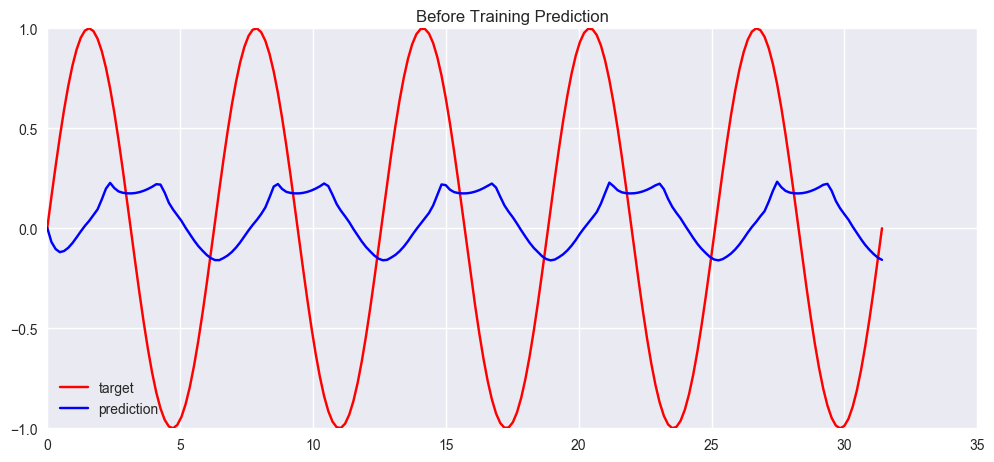

In [5]:
"""
Before training, the RNN ouptuts the curve like this...
"""

plt.figure(1, figsize=(12, 5))


# Plot after all training completes
pred_lst = []

# Re-initialize hidden state
hidden1 = Variable(torch.zeros(1, HIDDEN_SIZE))  
hidden2 = Variable(torch.zeros(1, HIDDEN_SIZE))  

for t in range(len(x_np)):
    x = Variable(torch.from_numpy(x_np[t:t+1, :]))
    
    predict, hidden1, hidden2 = rnn2(x, hidden1, hidden2)
    pred_lst.append(predict.data[0][0])
    
    
plt.title('Before Training Prediction')
plt.plot(steps, y_np.flatten(), 'r', label='target')
plt.plot(steps, np.array(pred_lst), 'b', label='prediction')
plt.legend(loc='lower left')

plt.show()

In [6]:
# Train for __ epochs, an epoch means that every data point should be picked once in expectation   
for epoch in range(100):
    
    for iteration in range(int(N/TIME_STEP)):
        
        # Pick start index in the dataset to create a mini-batch. Consider sequences of length TIME_STEP+SKIP.
        
        """
        *Trick* it would be problematic to always start training with empty hidden state, so we sample a longer
                sequence (TIME_STEP + SKIP); perform a complete forward pass but only backprop for TIME_STEP many
                steps.
        """
        start = np.random.randint(N)
        prestart = max(start - SKIP, 0)
        end = min(start + TIME_STEP, 200)
        

        # Extract mini-batch
        trainX = x_np[prestart:end, :]
        trainY = y_np[prestart:end, :]
        
        # Initialize hidden state
        hidden1 = Variable(torch.zeros(1, HIDDEN_SIZE))  
        hidden2 = Variable(torch.zeros(1, HIDDEN_SIZE))
    
        # Forward pass and loss compute
        Loss = 0
        for t in range(len(trainX)):  # note it may be less that TIME_STEP+SKIP many time-steps

            x = Variable(torch.from_numpy(x_np[t:t+1, :]))
            y = Variable(torch.from_numpy(y_np[t:t+1, :]))

            predict, hidden1, hidden2 = rnn2(x, hidden1, hidden2)
            

            # Skip the first SKIP many time-steps for the reason stated above.
            if t < start - prestart: continue
            
            
            loss = loss_fn(predict, y)
            Loss += loss
            

        # Backward pass and param update
        optim.zero_grad()
        Loss.backward(retain_variables=True)
        optim.step()

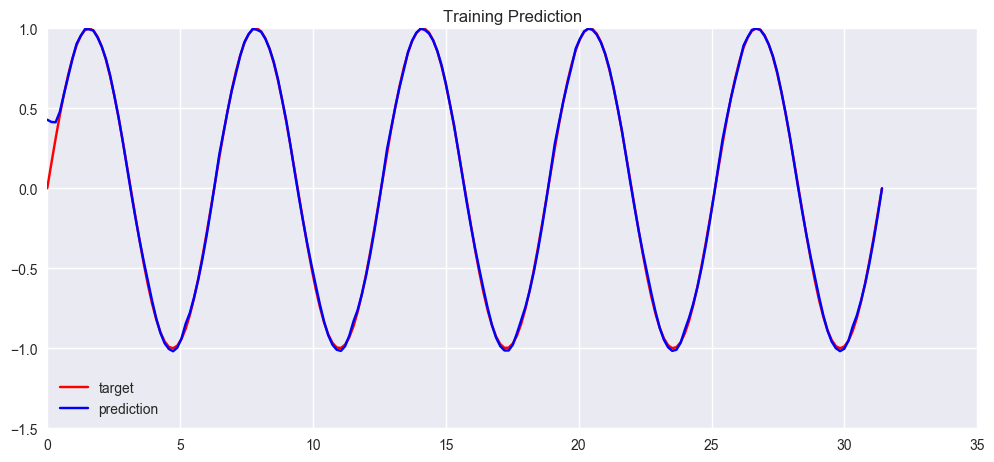

In [7]:
"""
Training Evaluation
"""        

plt.figure(1, figsize=(12, 5))


# Plot after all training completes
pred_lst = []

# Re-initialize hidden state
hidden1 = Variable(torch.zeros(1, HIDDEN_SIZE))  
hidden2 = Variable(torch.zeros(1, HIDDEN_SIZE))

for t in range(len(x_np)):
    x = Variable(torch.from_numpy(x_np[t:t+1, :]))
    
    predict, hidden1, hidden2 = rnn2(x, hidden1, hidden2)
    pred_lst.append(predict.data[0][0])
    
    
plt.title('Training Prediction')
plt.plot(steps, y_np.flatten(), 'r', label='target')
plt.plot(steps, np.array(pred_lst), 'b', label='prediction')
plt.legend(loc='lower left')

plt.show()

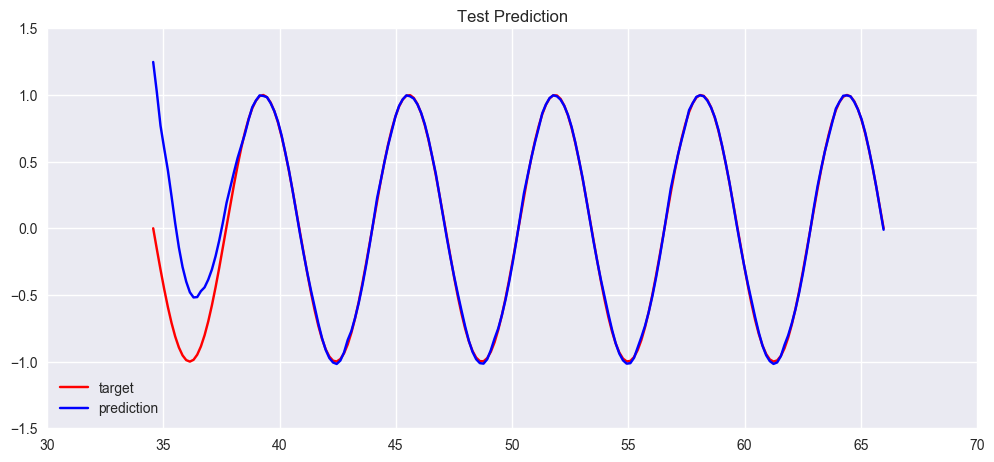

In [8]:
"""
Test Evaluation
"""

plt.figure(1, figsize=(12, 5))


# Prediction on "unseen" data
steps2 = np.linspace(11* np.pi, 21* np.pi, 200, dtype=np.float32)[:, np.newaxis]
x_np2 = np.cos(steps2)
y_np2 = np.sin(steps2)# + np.random.randn(200, 1).astype(np.float32)* 0.2

pred_lst2 = []

# Re-initialize hidden state
hidden1 = Variable(torch.zeros(1, HIDDEN_SIZE))  
hidden2 = Variable(torch.zeros(1, HIDDEN_SIZE))

for t in range(len(x_np2)):
    x = Variable(torch.from_numpy(x_np2[t:t+1, :]))
    
    predict, hidden1, hidden2 = rnn2(x, hidden1, hidden2)
    pred_lst2.append(predict.data[0][0])
    
    
plt.title('Test Prediction')
plt.plot(steps2, y_np2.flatten(), 'r', label='target')
plt.plot(steps2, np.array(pred_lst2), 'b', label='prediction')
plt.legend(loc='lower left')

plt.show()